# Challenge 


We expect you to: 
  - finish the test in 2-3 hours
  - return the results in 1 week but the sooner the better
  - build an end-to-end pipeline for the task
  - showcase your understanding of various aspects of ML: ETL, model building and selection, evaluation, etc.
  - develop in python (jupyter notebooks) with reasonable comments
  - use version control with appropriate commit messages

The test is about building a CTR prediction model with one of the datasets:
  - https://www.kaggle.com/c/online-advertising-challenge-spring-2018
  - https://www.kaggle.com/c/avazu-ctr-prediction
  - https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection
  - https://www.kaggle.com/c/criteo-display-ad-challenge

# Data 

For this exercise [Avazu dataset](https://www.kaggle.com/c/avazu-ctr-prediction/overview) is used. There is no particular reason for choosing one dataset over another. 

Data was downloaded from the link above and saved into the `data` folder. After decompressing, the files were renamed to *csv* extension. Please refer to the link for more data description. 

In [29]:
! head ./data/avazu-ctr-prediction/train.csv

In [30]:
# Reading the data with Dask - in parallel 
import dask.dataframe as dd

# Define schema dict; this will force schema when reding data. 
dict_schema = {'id': 'float64'}

train = dd.read_csv(urlpath='./data/avazu-ctr-prediction/train.csv', dtype = dict_schema)
test = dd.read_csv(urlpath='./data/avazu-ctr-prediction/test.csv', dtype = dict_schema)

# print data head and shape
print('train shape = {}'.format(train.compute().shape))
print('test shape = {}'.format(test.compute().shape))

display(train.head())

train shape = (40428967, 24)
test shape = (4577464, 23)


,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [31]:
train.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [32]:
test.columns

Index(['id', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [33]:
type(train)

dask.dataframe.core.DataFrame

**NOTE**

**This dataset appears to be big enough to not accommodate light ML training on local machine. In this context, I will limit the analysis to 1M observations in the training dataset and the respective about 2.5% in the testing dataset.**

**This is a limitation when it comes to the accuracy of the model. I assume the task is not necessarily concerned with accuracy (even though this is important), but rather with building end to end ML and feature engineering. Having said that, I can certainly use the cloud for more computing resources, but this is not explored here.**

In [35]:
# Sample the data and save to disk
sample_fraction = 0.025
train_sample = train.sample(frac=sample_fraction)
train_sample.compute().to_csv('./data/avazu-ctr-prediction/train_sample.csv', index = None)

test_sample = test.sample(frac=sample_fraction)
test_sample.compute().to_csv('./data/avazu-ctr-prediction/test_sample.csv', index = None)

In [61]:
# Reading the data back -- not needed now; just in case you start fresh. 

# Reading the data with Dask - in parallel 
import dask.dataframe as dd
dict_schema = {'id': 'float64', 'hour': 'object'}

train_sample = dd.read_csv(urlpath='./data/avazu-ctr-prediction/train_sample.csv', dtype = dict_schema).compute()
test_sample = dd.read_csv(urlpath='./data/avazu-ctr-prediction/test_sample.csv', dtype = dict_schema).compute()

print('train sample shape = {}'.format(train_sample.shape))
print('test sample shape = {}'.format(test_sample.shape))

train sample shape = (1010725, 24)
test sample shape = (114436, 23)


# Data Exploration

The aim of this section is not to conduct an intensive EDA (this was addressed in previous exercise), but to explore feature distribution and how it relates to the CTR. 

https://towardsdatascience.com/mobile-ads-click-through-rate-ctr-prediction-44fdac40c6ff


In [69]:
# Train and test have unique id  -- this will be removed as it is not used in predictions 

train_sample.drop('id', axis=1, inplace=True)
test_sample.drop('id', axis=1, inplace=True)

In [71]:
# Check the data types
display(train_sample.dtypes)


click                int64
hour                object
C1                   int64
banner_pos           int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type          int64
device_conn_type     int64
C14                  int64
C15                  int64
C16                  int64
C17                  int64
C18                  int64
C19                  int64
C20                  int64
C21                  int64
dtype: object

**Notes:**

- *hour* will be converted into *datetime*. the other object columns are mostly related to categorical variables. 

In [72]:
import datetime

def convert_date (x):
   try:
      return datetime.datetime.strptime(x, '%y%m%d%H')
   except:
      return x


train_sample['hour'] = train_sample['hour'].apply(convert_date)

## CTR description

This section explores the CTR distribution in relation to main features. The assumption is that by describing the data, some correlations can be visually seen. This will hopefully aid feature engineering task later on. 

In [84]:
print("Overall CTR: ")
round(train_sample.click.value_counts() / train_sample.shape[0], 2)

# The overall CTR = ~17%

Overall CTR: 


0    0.83
1    0.17
Name: click, dtype: float64

**I hypothesize time in the day is quite important for the final prediction. Ideally, month and day in the month as well as hour is important. These features will be extracted, but the prediction will be based on limited data: 1M records.**

### CTR by Hour

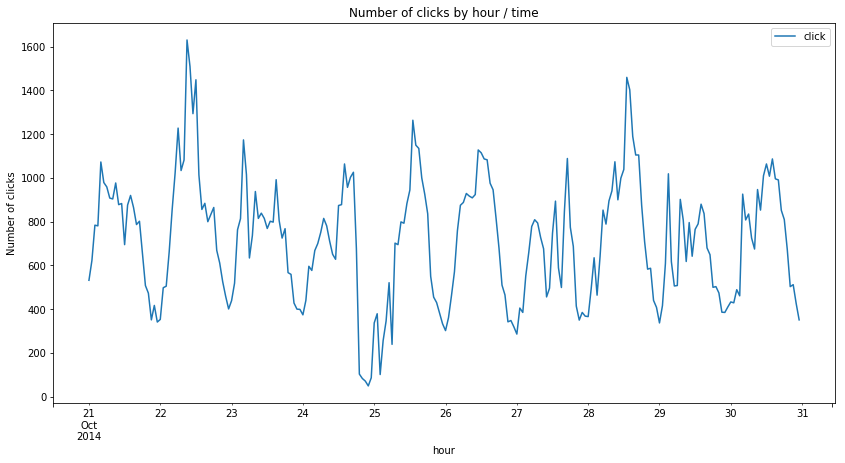

In [97]:
# Based on the sample data, the hourly clicks (timeline) look similar with a few peaks, particularily on the 22nd and 28th of Oct.

import seaborn as sns
import matplotlib.pyplot as plt

train_sample.groupby('hour').agg({'click':'sum'}).plot(figsize=(14,7))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour / time');

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  """


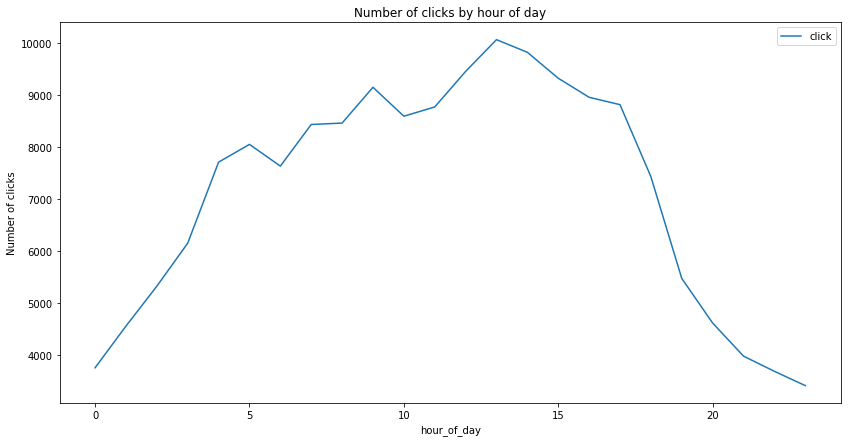

In [116]:
# The clicks distribution by hour of day looks quite different: Most of the clicks happen around midday and afternoon
# with least ones during the night. Business hours is as expected. 

train_sample['hour_of_day'] = train_sample['hour'].apply(lambda x: x.hour)
train_sample['day_name'] = train_sample['hour'].apply(lambda x: x.weekday_name)

train_sample.groupby('hour_of_day').agg({'click':'sum'}).plot(figsize=(14,7))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour of day');

Text(0,0.5,'CTR')

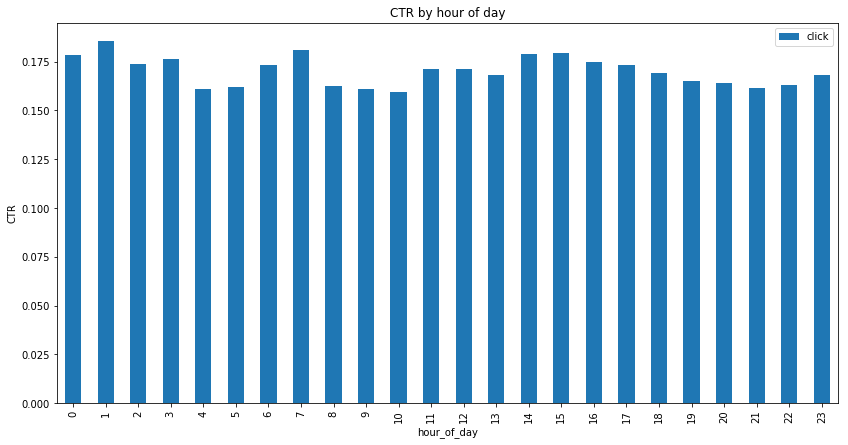

In [117]:
# There is consistency in terms of CTR by hour of the day with surprinsingly the highest value at hour 1am. 

def calculate_ctr(clicks):
    ctr = sum(clicks) / len(clicks)
    return ctr

train_sample.groupby('hour_of_day').agg({'click':calculate_ctr}).plot(kind='bar', figsize=(14,7))
plt.title('CTR by hour of day')
plt.ylabel('CTR')
    

Text(0,0.5,'CTR')

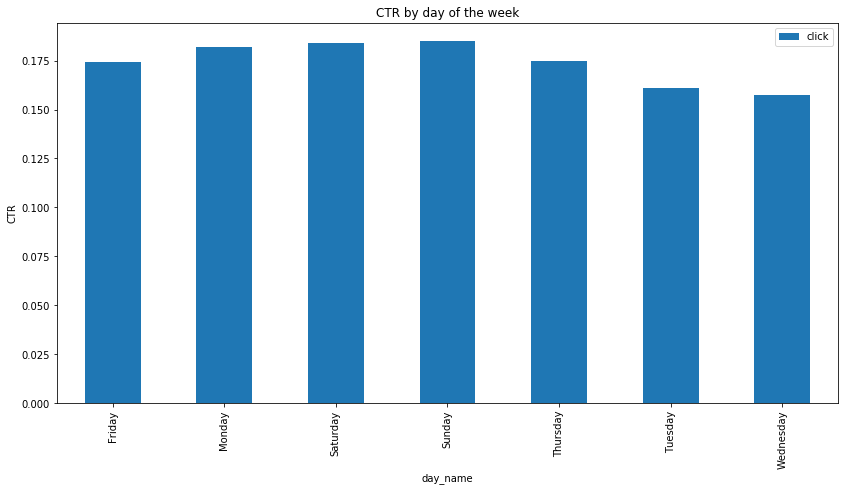

In [121]:
# The CTR is also consistent by day of the week, with weekend days having the highest values. 

train_sample.groupby('day_name').agg({'click':calculate_ctr}).plot(kind='bar', figsize=(14,7))
plt.title('CTR by day of the week')
plt.ylabel('CTR')


### CTR by other features - INTERACTIVE


**Notes:**

- below you can see top 20 categories with most impressions and related CTR scores. 

---



- **C1** categorical data shows that value 1002 has the higest CTR rate, but 92% of the values in this column are 1005. Adding more adds on value 1002 looks sensible. 
- 72% of the **banner position** is at position 0, but this does not relate to the highest CTR score. Pos 7 has the highest CTR score. Increasing the number of ads placed on banner position 7 seems to be a good idea.
- the **site feateures** shows various distribution as related to the CTR score with some scores very high (i.e. 70%)
- **device**
    - 82% of the impressions are seen on one device id (a99f214a), but most of the converting ads are not on this device id. 
    - there are ~0.5M unique device ip and only a few with high CTR score --> this will be rm from the training data. 
    - device model CTR distribution is quite varied 
    - device type 1 has the most ads shown but this is 2nd in terms of CTR score. 
- the **app features** show various CTR distributions.    
- **categorical features C14-C21** show various distribution. If the number of unique values is generally high, then the count distribution is long. 
    - ~47% of the C20 feature is classed as -1 which may be missing. 

In [155]:

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_CTR(column):
    total_values = len(train_sample[column].unique())
    print("There are {} unique values in {}.\n".format(total_values, column))
    
    values = train_sample[column].value_counts()/len(train_sample)
    print("% of value in the whole feature")
    display(values.head(20))

    train_sample.groupby(column).agg({'click':calculate_ctr}).head(20).plot(kind='bar', figsize=(14,7))
    title = "CTR by " + str(column)
    plt.title(title)
    plt.ylabel('CTR')
    

interact(plot_CTR, column=train_sample.columns);    

interactive(children=(Dropdown(description='column', options=('click', 'hour', 'C1', 'banner_pos', 'site_id', …

## Feature selection 

- The *id* was previously removed. The *hour* will also be removed as it was converted into hour of day and day of the week. 
- Even though some features come as int64 type, all features will be treated as categorical. In some cases the unique values of the features is very high (i.e. device ip - 0.5M) which may need to be reduced for computation speed. 


In [159]:
# train_sample.drop('hour', axis=1, inplace=True)

train_sample.dtypes

click                int64
C1                   int64
banner_pos           int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type          int64
device_conn_type     int64
C14                  int64
C15                  int64
C16                  int64
C17                  int64
C18                  int64
C19                  int64
C20                  int64
C21                  int64
hour_of_day          int64
day_name            object
dtype: object